<img src="img.jpg">

# Workout Classification
Now it's possible to collect a large amount of data about personal movement using activity monitoring devices such as a [Fitbit](http://www.fitbit.com), [NikeFuelband](http://www.nike.com/us/en_us/c/nikeplus-fuelband), or [Jawbone Up](https://jawbone.com/up). These type of devices are part of the "quantified self" movement, a group of enthusiasts who take measurements about themselves regularly to improve their health or to find patterns in their behavior. Unfurtunatelly, these data remain under-utilized both because the raw data are hard to obtain and there is a lack of statistical methods and software for processing and interpreting the data.

Usually, people quantify the amount of exercise they do but don't the quality of it. The objective of this project is to use the data from accelerometers on the belt, forearm, arm, and dumbbell to classify when an exercise is done correctly or not.

This project is structured as follows:
1. [Understanding the Data](#Understanding_the_Data)
    1. [Descriptive and Exploratory Analysis](#Descriptive_and_Exploratory_Analysis)
        1. [Anomaly Detection](#Anomaly_Detection)
    2. [Training and Validation Dataset](#Training_and_Validation_Dataset)
2. [Feature Selection/Importance](#Feature_Selection_Importance)
3. [Classification Model](#Classification_Model)
4. [Conclusions and Remarks](#Conclusions_and_Remarks)

## Understanding the Data
<a id='Understanding_the_Data'></a>

This project is possible thanks to the data obtained from [here](http://groupware.les.inf.puc-rio.br/har#weight_lifting_exercises). Also, the owners of this dataset have an [available publication](http://groupware.les.inf.puc-rio.br/public/papers/2013.Velloso.QAR-WLE.pdf) that you can checkout. 

The experimental design was conducted in accordance with the next points:
1. The exercises were performed by 6 young (20-28 years old) healthy participants.
2. Each participant did 10 repetitions of "Unilateral Dumbbell Biceps Curl" in 5 different fashions:
    1. _Class A_: Exactly as the specifications (high quality performance)
    2. _Class B_: Throwing the elbows to the front (mistake).
    3. _Class C_: Lifting the dumbbell only halfway (mistake).
    4. _Class D_: Lowering the dumbbell only halfway (mistake).
    5. _Class E_: Throwing the hips to the front (mistake).
3. Four sensors were used to collect the data (in the glove, armband, lumbar belt and dumbbell), as it is represented in the below figure (this figure was inspired by the schema proposed by the author [here](http://groupware.les.inf.puc-rio.br/public/papers/2013.Velloso.QAR-WLE.pdf)).
4. Each sensor acts as a center of a euclidean coordinates system, so, for each sensor was possible to record it's [intrinsic rotations](https://en.wikipedia.org/wiki/Euler_angles) (yaw, pitch, and roll), in addition to the [gyroscope](https://en.wikipedia.org/wiki/Gyroscope), [accelerometer](https://en.wikipedia.org/wiki/Accelerometer), and [magnetometer](https://en.wikipedia.org/wiki/Magnetometer) values for each axis of the coordinate system.
    
<img src="workout_body.png">

More details about this data can be consulted [here](http://groupware.les.inf.puc-rio.br/har#weight_lifting_exercises).

In [1]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load Dataset
curl_variation=pd.read_csv('WearableComputing_weight_lifting_exercises_biceps_curl_variations.csv',low_memory=False)
print('The dataset is composed by {} instances and {} features.'.format(
    curl_variation.shape[0],curl_variation.shape[1]))

The dataset is composed by 39242 instances and 159 features.


In [3]:
# Display the head of our data frame
pd.set_option('display.max_columns',None)
curl_variation.head()

,user_name,raw_timestamp_part_1,raw_timestamp_part_2,cvtd_timestamp,new_window,num_window,roll_belt,pitch_belt,yaw_belt,total_accel_belt,kurtosis_roll_belt,kurtosis_picth_belt,kurtosis_yaw_belt,skewness_roll_belt,skewness_roll_belt.1,skewness_yaw_belt,max_roll_belt,max_picth_belt,max_yaw_belt,min_roll_belt,min_pitch_belt,min_yaw_belt,amplitude_roll_belt,amplitude_pitch_belt,amplitude_yaw_belt,var_total_accel_belt,avg_roll_belt,stddev_roll_belt,var_roll_belt,avg_pitch_belt,stddev_pitch_belt,var_pitch_belt,avg_yaw_belt,stddev_yaw_belt,var_yaw_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,accel_belt_x,accel_belt_y,accel_belt_z,magnet_belt_x,magnet_belt_y,magnet_belt_z,roll_arm,pitch_arm,yaw_arm,total_accel_arm,var_accel_arm,avg_roll_arm,stddev_roll_arm,var_roll_arm,avg_pitch_arm,stddev_pitch_arm,var_pitch_arm,avg_yaw_arm,stddev_yaw_arm,var_yaw_arm,gyros_arm_x,gyros_arm_y,gyros_arm_z,accel_arm_x,accel_arm_y,accel_arm_z,magnet_arm_x,magnet_arm_y,magnet_arm_z,kurtosis_roll_arm,kurtosis_picth_arm,kurtosis_yaw_arm,skewness_roll_arm,skewness_pitch_arm,skewness_yaw_arm,max_roll_arm,max_picth_arm,max_yaw_arm,min_roll_arm,min_pitch_arm,min_yaw_arm,amplitude_roll_arm,amplitude_pitch_arm,amplitude_yaw_arm,roll_dumbbell,pitch_dumbbell,yaw_dumbbell,kurtosis_roll_dumbbell,kurtosis_picth_dumbbell,kurtosis_yaw_dumbbell,skewness_roll_dumbbell,skewness_pitch_dumbbell,skewness_yaw_dumbbell,max_roll_dumbbell,max_picth_dumbbell,max_yaw_dumbbell,min_roll_dumbbell,min_pitch_dumbbell,min_yaw_dumbbell,amplitude_roll_dumbbell,amplitude_pitch_dumbbell,amplitude_yaw_dumbbell,total_accel_dumbbell,var_accel_dumbbell,avg_roll_dumbbell,stddev_roll_dumbbell,var_roll_dumbbell,avg_pitch_dumbbell,stddev_pitch_dumbbell,var_pitch_dumbbell,avg_yaw_dumbbell,stddev_yaw_dumbbell,var_yaw_dumbbell,gyros_dumbbell_x,gyros_dumbbell_y,gyros_dumbbell_z,accel_dumbbell_x,accel_dumbbell_y,accel_dumbbell_z,magnet_dumbbell_x,magnet_dumbbell_y,magnet_dumbbell_z,roll_forearm,pitch_forearm,yaw_forearm,kurtosis_roll_forearm,kurtosis_picth_forearm,kurtosis_yaw_forearm,skewness_roll_forearm,skewness_pitch_forearm,skewness_yaw_forearm,max_roll_forearm,max_picth_forearm,max_yaw_forearm,min_roll_forearm,min_pitch_forearm,min_yaw_forearm,amplitude_roll_forearm,amplitude_pitch_forearm,amplitude_yaw_forearm,total_accel_forearm,var_accel_forearm,avg_roll_forearm,stddev_roll_forearm,var_roll_forearm,avg_pitch_forearm,stddev_pitch_forearm,var_pitch_forearm,avg_yaw_forearm,stddev_yaw_forearm,var_yaw_forearm,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z,classe
0,eurico,1322489729,34670,28/11/2011 14:15,no,1,3.70,41.6,-82.8,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.02,0.18,0.02,-3,-18,22,387,525,-267,132.0,-43.7,-53.6,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.65,-0.61,-0.02,143,30,-346,556,-205,-374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.235540,11.698847,104.264727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.31,0.16,0.08,5,21,37,-471.0,191.0,277.0,-111.0,26.5,138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.05,-0.37,-0.43,-170.0,155.0,184,-1160.0,1400.0,-876.0,E
1,eurico,1322489729,62641,28/11/2011 14:15,no,1,3.66,42.8,-82.5,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.96,0.14,0.05,-2,-13,16,405,512,-254,129.0,-45.3,-49.0,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.79,-0.64,-0.11,146,35,-339,599,-206,-335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.824418,9.645819,100.228053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.31,0.14,0.07,4,22,35,-472.0,184.0,281.0,-112.0,26.2,138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,NaN,NaN,NaN,NaN,NaN,

If you explore the above table, you can see that a lot of variables have not assigned values at least in the first 5 instances. Therefore, let's see what is the average of NaN for each feature in our dataset and erase the variables with more than 40% of missing values.
> This threshold was selected taking into account that best algorithms/methods have a breaking point of 50%, this is, it's necessary at least 50% of the data in the distribution to make relative accurate estimations (for example the median). If we are going to impute the missing values, we need enough information in the variable, otherwise, it's better to drop the variable.

In [4]:
# Compute the average of rows with missing values per variable and only keep columns with 60%+ of information
pd.set_option('display.max_rows',None)
columns_out=curl_variation.columns[(curl_variation.isna().sum()/len(curl_variation)>0.4).values]
print('The {}% of the variables have more than 40% of the observations as NaN.'.format(
    round(100*len(columns_out)/curl_variation.shape[1],2)))

The 62.89% of the variables have more than 40% of the observations as NaN.


In [5]:
# Drop the columns with more than 40% of missing data
curl_variation.drop(columns=columns_out,inplace=True)
print('Now our data is composed by {} observations and {} variables'.format(
    curl_variation.shape[0],curl_variation.shape[1]))
curl_variation.head()

Now our data is composed by 39242 observations and 59 variables


,user_name,raw_timestamp_part_1,raw_timestamp_part_2,cvtd_timestamp,new_window,num_window,roll_belt,pitch_belt,yaw_belt,total_accel_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,accel_belt_x,accel_belt_y,accel_belt_z,magnet_belt_x,magnet_belt_y,magnet_belt_z,roll_arm,pitch_arm,yaw_arm,total_accel_arm,gyros_arm_x,gyros_arm_y,gyros_arm_z,accel_arm_x,accel_arm_y,accel_arm_z,magnet_arm_x,magnet_arm_y,magnet_arm_z,roll_dumbbell,pitch_dumbbell,yaw_dumbbell,total_accel_dumbbell,gyros_dumbbell_x,gyros_dumbbell_y,gyros_dumbbell_z,accel_dumbbell_x,accel_dumbbell_y,accel_dumbbell_z,magnet_dumbbell_x,magnet_dumbbell_y,magnet_dumbbell_z,roll_forearm,pitch_forearm,yaw_forearm,total_accel_forearm,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z,classe
0,eurico,1322489729,34670,28/11/2011 14:15,no,1,3.70,41.6,-82.8,3,2.02,0.18,0.02,-3,-18,22,387,525,-267,132.0,-43.7,-53.6,38,2.65,-0.61,-0.02,143,30,-346,556,-205,-374,51.235540,11.698847,104.264727,4,-0.31,0.16,0.08,5,21,37,-471.0,191.0,277.0,-111.0,26.5,138.0,30,-0.05,-0.37,-0.43,-170.0,155.0,184,-1160.0,1400.0,-876.0,E
1,eurico,1322489729,62641,28/11/2011 14:15,no,1,3.66,42.8,-82.5,2,1.96,0.14,0.05,-2,-13,16,405,512,-254,129.0,-45.3,-49.0,38,2.79,-0.64,-0.11,146,35,-339,599,-206,-335,55.824418,9.645819,100.228053,4,-0.31,0.14,0.07,4,22,35,-472.0,184.0,281.0,-112.0,26.2,138.0,31,-0.06,-0.37,-0.59,-178.0,164.0,182,-1150.0,1410.0,-871.0,E
2,eurico,1322489729,70653,28/11/2011 14:15,no,1,3.58,43.7,-82.3,1,1.88,0.08,0.05,-2,-6,8,409,511,-244,125.0,-46.8,-43.7,35,2.91,-0.69,-0.15,156,44,-307,613,-198,-319,55.469831,6.875244,101.084106,4,-0.31,0.16,0.05,3,23,37,-468.0,190.0,275.0,-114.0,26.0,137.0,32,-0.05,-0.27,-0.72,-182.0,172.0,185,-1130.0,1400.0,-863.0,E
3,eurico,1322489729,82654,28/11/2011 14:15,no,1,3.56,44.4,-82.1,1,1.80,0.03,0.08,-6,-5,7,422,513,-221,120.0,-48.1,-38.1,35,3.08,-0.72,-0.23,158,52,-305,646,-186,-268,55.944860,11.079297,99.784556,5,-0.31,0.16,0.07,5,24,38,-469.0,184.0,285.0,-115.0,25.8,137.0,33,0.02,-0.24,-0.79,-185.0,182.0,188,-1120.0,1400.0,-855.0,E
4,eurico,1322489729,90637,28/11/2011 14:15,no,1,3.57,45.1,-81.9,1,1.77,0.00,0.13,-4,-9,0,418,508,-208,115.0,-49.1,-31.7,34,3.20,-0.77,-0.25,163,55,-288,670,-175,-241,55.211739,11.426833,100.422583,4,-0.31,0.14,0.07,5,23,37,-468.0,189.0,292.0,-117.0,25.5,137.0,34,0.08,-0.27,-0.82,-188.0,195.0,188,-1100.0,1400.0,-843.0,E


In [6]:
# Check if exist other variable with NaN
var_with_nan=curl_variation.isna().sum()[curl_variation.isna().sum()!=0]
print('The remain variables with not assigned value are {} with {} missing values'.format(var_with_nan.index,
                                                                                        var_with_nan.values))

The remain variables with not assigned value are Index(['roll_dumbbell'], dtype='object') with [1] missing values


The above piece of information is important and we need to keep it in mind, but, for the moment let's see what is the datatype of our variables and convert the features to the correct datatype. After that, we can design a strategy to deal with this missing value.
> Because we have only one missing value, I don't think that erasing this instance could have an impact on the classification model, but I am curious about the class that this missing value belongs and the number of instances that we have in this class.    

If you print the data type of each variable (use `curl_variation.dtypes`), you can see that there are only 3 types of formats in our dataset (`int`, `float`, `object`). The below code print the variables that belongs to each format.

In [7]:
# Print out the variables data type
dictionary={types: curl_variation.select_dtypes(types).columns for types in ['object','int','float']}
dictionary

{'object': Index(['user_name', 'cvtd_timestamp', 'new_window', 'classe'], dtype='object'),
 'int': Index(['raw_timestamp_part_1', 'raw_timestamp_part_2', 'num_window',
        'total_accel_belt', 'accel_belt_x', 'accel_belt_y', 'accel_belt_z',
        'magnet_belt_x', 'magnet_belt_y', 'magnet_belt_z', 'total_accel_arm',
        'accel_arm_x', 'accel_arm_y', 'accel_arm_z', 'magnet_arm_x',
        'magnet_arm_y', 'magnet_arm_z', 'total_accel_dumbbell',
        'accel_dumbbell_x', 'accel_dumbbell_y', 'accel_dumbbell_z',
        'total_accel_forearm', 'accel_forearm_z'],
       dtype='object'),
 'float': Index(['roll_belt', 'pitch_belt', 'yaw_belt', 'gyros_belt_x', 'gyros_belt_y',
        'gyros_belt_z', 'roll_arm', 'pitch_arm', 'yaw_arm', 'gyros_arm_x',
        'gyros_arm_y', 'gyros_arm_z', 'roll_dumbbell', 'pitch_dumbbell',
        'yaw_dumbbell', 'gyros_dumbbell_x', 'gyros_dumbbell_y',
        'gyros_dumbbell_z', 'magnet_dumbbell_x', 'magnet_dumbbell_y',
        'magnet_dumbbell_z', 'ro

The above dictionary shows that the variables in the `float` data type group are correctly assigned, but in the object variables we have some of them that are  `datetime` and other are `categories` (factor variables). We also have a similar situation with some variables in the group `int`. Let's transform these variables to the correct type.

In [8]:
# Transform to datetime
date_time_var=['cvtd_timestamp','raw_timestamp_part_1',
           'raw_timestamp_part_2']
curl_variation.loc[:,date_time_var]=curl_variation.loc[:,date_time_var].apply(pd.to_datetime)
# Transform to category
categories=['user_name','new_window','classe']
curl_variation.loc[:,categories]=curl_variation.loc[:,categories].astype('category')
dictionary={types: curl_variation.select_dtypes(types).columns for types in ['object','int','float','category']}
dictionary

{'object': Index([], dtype='object'),
 'int': Index(['num_window', 'total_accel_belt', 'accel_belt_x', 'accel_belt_y',
        'accel_belt_z', 'magnet_belt_x', 'magnet_belt_y', 'magnet_belt_z',
        'total_accel_arm', 'accel_arm_x', 'accel_arm_y', 'accel_arm_z',
        'magnet_arm_x', 'magnet_arm_y', 'magnet_arm_z', 'total_accel_dumbbell',
        'accel_dumbbell_x', 'accel_dumbbell_y', 'accel_dumbbell_z',
        'total_accel_forearm', 'accel_forearm_z'],
       dtype='object'),
 'float': Index(['roll_belt', 'pitch_belt', 'yaw_belt', 'gyros_belt_x', 'gyros_belt_y',
        'gyros_belt_z', 'roll_arm', 'pitch_arm', 'yaw_arm', 'gyros_arm_x',
        'gyros_arm_y', 'gyros_arm_z', 'roll_dumbbell', 'pitch_dumbbell',
        'yaw_dumbbell', 'gyros_dumbbell_x', 'gyros_dumbbell_y',
        'gyros_dumbbell_z', 'magnet_dumbbell_x', 'magnet_dumbbell_y',
        'magnet_dumbbell_z', 'roll_forearm', 'pitch_forearm', 'yaw_forearm',
        'gyros_forearm_x', 'gyros_forearm_y', 'gyros_forearm_z',

Now, the variable types look that should and we can move back to our missing value. The first step is to look at the class that this missing value belongs to.

In [9]:
# Look at the class that belongs the missing value
curl_variation.loc[curl_variation['roll_dumbbell'].isna().values,'classe']

8136    A
Name: classe, dtype: category
Categories (5, object): [A, B, C, D, E]

As we can see, this missing value belong to class A, and the number of instances in this class is 11159 (see below), so, as was discussed before, the best option here is to erase this observation from our data because, given the amount of data in this class, one less observation will not have an impact in the model.

In [10]:
# Print the number of instances by classes
print(curl_variation['classe'].value_counts())
# Erase the instance with the missing value
curl_variation.dropna(inplace=True)

A    11159
B     7593
E     7214
C     6844
D     6432
Name: classe, dtype: int64


We know that our variables are related to the sensors data, but after the erase of some features, we don't know how many variables per sensor remains in the data frame. In the below data frame you can see that the variables per location (13) are the same, given a total of 52 variables related with the reading of the sensor. The remaining 7 variables are descriptive and datetime variable and the target variable (`class`).

In [11]:
# Number of variables per sensor location
import re
pd.DataFrame({val: [string for string in list(curl_variation.columns) if re.search(rf'\w*_{val}\w*', string)] for 
 val in ['belt','arm','forearm','dumbbell']})

,belt,arm,forearm,dumbbell
0,roll_belt,roll_arm,roll_forearm,roll_dumbbell
1,pitch_belt,pitch_arm,pitch_forearm,pitch_dumbbell
2,yaw_belt,yaw_arm,yaw_forearm,yaw_dumbbell
3,total_accel_belt,total_accel_arm,total_accel_forearm,total_accel_dumbbell
4,gyros_belt_x,gyros_arm_x,gyros_forearm_x,gyros_dumbbell_x
5,gyros_belt_y,gyros_arm_y,gyros_forearm_y,gyros_dumbbell_y
6,gyros_belt_z,gyros_arm_z,gyros_forearm_z,gyros_dumbbell_z
7,accel_belt_x,accel_arm_x,accel_forearm_x,accel_dumbbell_x
8,accel_belt_y,accel_arm_y,accel_forearm_y,accel_dumbbell_y
9,accel_belt_z,accel_arm_z,accel_forearm_z,accel_dumbbell_z


At this point, if you directly go and fit a machine learning algorithm, probably the current shape of this dataset could be enough, but, if you really want to understand your data, or if we want to develop some decriptive or exploratory statistical analysis, this structure doesn't look very promising because it is totally messy. Following the guide of Hadley Wickham in his paper [Tidy Data](http://vita.had.co.nz/papers/tidy-data.pdf), our dataset have two main problems:
1. Each variable doesn't form a column: The position of the sensors (arm, forearm, belt, dumbbell), the kind of devices (accelerometer, gyroscope, magnetometer) and the Axis (x,y,z) of the coordinates systems are independents variables that have been merge in our dataset.
2. We have multiple observations units: Roll, pitch, yaw, and total_accel_belt should be in an independent table. 

Now, we have some options to deal with these probelms:
1. Split the data frame into two tables (one with the variables roll, pitch, and yaw and the other with the rest of features). 
    > This path gives us the opportunity to really get tidy data, but in the future we are going to have a problem because variables in differents data frames could be important for our machine learning approach. 
2. Create new categorical variables: 1 for the location of the sensor (belt, arm, forearm, dumbbell), 1 for the type of device (gyroscope, accelerometer, and magnetometer), 1 for the axis (x,y,z) and one for the gaussian coordinate system (roll, pitch, yaw).
    > The back draw here is that the variables in the Gaussian coordinate system are going to have a lot of missing values. This is because we only have one lecture of these variables per position and it doesn't depend on the device or axis (see the above table).

One partial solution (at least the one that I thought about) is to include only one categorical variable with the location of the sensors (belt, arm, forearm, dumbbell) and conserve all the other categories together. With this option, we aren't going to have a tidy dataset, but at least all the features will remain in the same dataset and we are going to reduce the dimensionality of or data 4 times.

> **Note**: I had to split the data in two in a form that the melt and unmelt operation were feasible in my computer. After these operations, I merged the data frames again. If you do directly these operation conserving all the categorical variables, you are going to obtain a lot of observations in the melted data frame ($\mbox{#categorical_variables} \times \mbox{#original_instances} \times \mbox{#numerical_variables}$), and your computer could be run out of memory.

In [12]:
# Create an index variable to identify uniquely each instance
curl_variation.reset_index(inplace=True)
# Create a data frame with the categorical variables -------------------
    # Categorical varibles
var=[string for string in list(curl_variation.columns) if 
 re.search(r'^(?!.*(belt|arm|forearm|dumbbell)).', string)]
# New data frame
cat_df=curl_variation[var]
#-----------------------------------------------------------------------
# Create a data frame with the numerical variables and index
var=[string for string in list(curl_variation.columns) if 
 re.search(r'belt|forearm|arm|dumbbell|index', string)]
num_df=curl_variation[var]
#-----------------------------------------------------------------------

In [13]:
# Melt the information in num_df
num_df_melt=pd.melt(num_df,id_vars='index')
num_df_melt.head(10)

,index,variable,value
0,0,roll_belt,3.70
1,1,roll_belt,3.66
2,2,roll_belt,3.58
3,3,roll_belt,3.56
4,4,roll_belt,3.57
5,5,roll_belt,3.45
6,6,roll_belt,3.31
7,7,roll_belt,2.91
8,8,roll_belt,2.31
9,9,roll_belt,2.00


In [14]:
# Split the variables in "variable" and include it in the "num_df_melt" dataframe
# This is going to create a new categorical variable called "Location" (belt, arm, forearm, dumbbell).
# Also, this code erase the these 4 locations from "variable"
test1=pd.Series(num_df_melt['variable']).str.extract(r'(?P<First>\w*)_(?P<Location>forearm|belt|dumbbell|arm)(?P<Second>\w*)')
num_df_melt['Location']=test1['Location']
num_df_melt['variable']=test1['First'] + test1['Second']
num_df_melt.head()

,index,variable,value,Location
0,0,roll,3.70,belt
1,1,roll,3.66,belt
2,2,roll,3.58,belt
3,3,roll,3.56,belt
4,4,roll,3.57,belt


In [15]:
# Unmelt to create new variables using the column "variable"
num_df_melt=num_df_melt.pivot_table(values='value', index=['index',
                                                             'Location'], 
                       columns='variable',aggfunc=lambda x: x)
num_df_melt.reset_index(inplace=True) # Reset the index
num_df_melt.head(10)

variable,index,Location,accel_x,accel_y,accel_z,gyros_x,gyros_y,gyros_z,magnet_x,magnet_y,magnet_z,pitch,roll,total_accel,yaw
0,0,arm,143.0,30.0,-346.0,2.65,-0.61,-0.02,556.0,-205.0,-374.0,-43.700000,132.000000,38.0,-53.600000
1,0,belt,-3.0,-18.0,22.0,2.02,0.18,0.02,387.0,525.0,-267.0,41.600000,3.700000,3.0,-82.800000
2,0,dumbbell,5.0,21.0,37.0,-0.31,0.16,0.08,-471.0,191.0,277.0,11.698847,51.235540,4.0,104.264727
3,0,forearm,-170.0,155.0,184.0,-0.05,-0.37,-0.43,-1160.0,1400.0,-876.0,26.500000,-111.000000,30.0,138.000000
4,1,arm,146.0,35.0,-339.0,2.79,-0.64,-0.11,599.0,-206.0,-335.0,-45.300000,129.000000,38.0,-49.000000
5,1,belt,-2.0,-13.0,16.0,1.96,0.14,0.05,405.0,512.0,-254.0,42.800000,3.660000,2.0,-82.500000
6,1,dumbbell,4.0,22.0,35.0,-0.31,0.14,0.07,-472.0,184.0,281.0,9.645819,55.824418,4.0,100.228053
7,1,forearm,-178.0,164.0,182.0,-0.06,-0.37,-0.59,-1150.0,1410.0,-871.0,26.200000,-112.000000,31.0,138.000000
8,2,arm,156.0,44.0,-307.0,2.91,-0.69,-0.15,613.0,-198.0,-319.0,-46.800000,125.000000,35.0,-43.700000
9,2,belt,-2.0,-6.0,8.0,1.88,0.08,0.05,409.0,511.0,-244.0,43.700000,3.580000,1.0,-82.300000


In [16]:
# Now it's time to merge the dataframes using "index"
tidy_df=cat_df.merge(num_df_melt,how='left',on='index')
# Drop the variable "index"
tidy_df.drop(columns='index',inplace=True)
# Convert to category the variable "Location"
tidy_df['Location']=tidy_df['Location'].astype('category')
tidy_df.head()

,user_name,raw_timestamp_part_1,raw_timestamp_part_2,cvtd_timestamp,new_window,num_window,classe,Location,accel_x,accel_y,accel_z,gyros_x,gyros_y,gyros_z,magnet_x,magnet_y,magnet_z,pitch,roll,total_accel,yaw
0,eurico,1970-01-01 00:00:01.322489729,1970-01-01 00:00:00.000034670,2011-11-28 14:15:00,no,1,E,arm,143.0,30.0,-346.0,2.65,-0.61,-0.02,556.0,-205.0,-374.0,-43.700000,132.00000,38.0,-53.600000
1,eurico,1970-01-01 00:00:01.322489729,1970-01-01 00:00:00.000034670,2011-11-28 14:15:00,no,1,E,belt,-3.0,-18.0,22.0,2.02,0.18,0.02,387.0,525.0,-267.0,41.600000,3.70000,3.0,-82.800000
2,eurico,1970-01-01 00:00:01.322489729,1970-01-01 00:00:00.000034670,2011-11-28 14:15:00,no,1,E,dumbbell,5.0,21.0,37.0,-0.31,0.16,0.08,-471.0,191.0,277.0,11.698847,51.23554,4.0,104.264727
3,eurico,1970-01-01 00:00:01.322489729,1970-01-01 00:00:00.000034670,2011-11-28 14:15:00,no,1,E,forearm,-170.0,155.0,184.0,-0.05,-0.37,-0.43,-1160.0,1400.0,-876.0,26.500000,-111.00000,30.0,138.000000
4,eurico,1970-01-01 00:00:01.322489729,1970-01-01 00:00:00.000062641,2011-11-28 14:15:00,no,1,E,arm,146.0,35.0,-339.0,2.79,-0.64,-0.11,599.0,-206.0,-335.0,-45.300000,129.00000,38.0,-49.000000


Finally, our "semi-tidy" data frame is ready. From this point, all the remaining analysis will be done using this new data frame called `tidy_df`.

### Descriptive and Exploratory Analysis
<a id='Descriptive_and_Exploratory_Analysis'></a>
So far, we make a significant dimensionality reduction of our dataset (we go from $\approx 150$ features to only 21), and now, it's the moment to describe and visualize the data in order to have a better clue of what is going on.     
The results below show that the number of missing values in our data is zero, which it's because before the `melt` operation we cleaned our data of NaN. Now, we have a total of 156964 instances, which is the result of multiply the number of `Location`s (4) by the number of observations in the raw dataset (39241). Also, our data shows that in the experiment were involved 6 participants and 5 classification categories (see descriptive table below), so, everything looks good.

In [17]:
# Describe the categorical variables
print('The number of missing values in the data is {} ==> Great!'.format(tidy_df.isna().sum().sum()))
tidy_df.select_dtypes('category').describe()

The number of missing values in the data is 0 ==> Great!


,user_name,new_window,classe,Location
count,156964,156964,156964,156964
unique,6,2,5,4
top,adelmo,no,A,forearm
freq,31088,153608,44632,39241


The below table provides a lot of useful information but in my opinion, an important point is to note that the values from different devices (accelerometer, gyroscope, ...) are recorded in different scales. The owners of this dataset don't specify the measure units of the devices, but after a little research I am pretty sure that our variables are recorded using the next units:
* Accelerometer: Meters per second squared ($m/s^2$).
* Gyroscope: Degrees per second ($^o/s$).
* Magenetometer: Microtesla ($\mu T$).
* pitch, roll \& yaw: Grades ($^o$).      

You can obtain more information about these devices [here](https://www.sparkfun.com/products/retired/10736). 

For now, in this descriptive and exploratory data analysis, we don't need to scale these variables because we are going to explore only the relationship between the variables and the `classe` (target variable), but this normalization will be developed in the section [Training and Validation Dataset](#Training_and_Validation_Dataset).

In [121]:
# Describe the numerical variables
tidy_df.describe()

,num_window,accel_x,accel_y,accel_z,gyros_x,gyros_y,gyros_z,magnet_x,magnet_y,magnet_z,pitch,roll,total_accel,yaw
count,156964.000000,156964.000000,156964.000000,156964.000000,156964.000000,156964.000000,156964.000000,156964.000000,156964.000000,156964.000000,156964.000000,156964.000000,156964.000000,156964.000000
mean,432.328610,-40.047373,69.756375,-59.230365,0.089809,-0.020572,0.037690,-100.180317,338.283073,101.353093,-0.905036,35.024021,21.331050,2.111803
std,247.964347,135.807146,133.351372,122.272403,1.462541,1.940257,1.111649,400.555185,360.184728,386.488843,31.102601,82.307463,13.491101,89.611147
min,1.000000,-498.000000,-690.000000,-640.000000,-339.000000,-7.030000,-52.000000,-1280.000000,-3600.000000,-973.000000,-149.593648,-180.000000,0.000000,-180.000000
25%,222.000000,-109.000000,-1.000000,-162.000000,-0.110000,-0.290000,-0.210000,-461.000000,201.000000,-302.000000,-25.100000,0.000000,9.000000,-83.100000
50%,428.000000,-17.000000,46.000000,-30.000000,0.060000,0.000000,-0.020000,-48.000000,384.000000,52.000000,2.630000,30.700000,19.000000,0.000000
75%,647.000000,26.000000,142.000000,28.000000,0.350000,0.180000,0.250000,126.000000,601.000000,480.000000,17.700000,115.000000,32.000000,81.300000
max,864.000000,479.000000,923.000000,319.000000,4.900000,516.000000,317.000000,785.000000,1480.000000,1090.000000,149.402444,180.000000,108.000000,180.000000


After some basic distribution visualization through boxplot, we can see that exist a lot of anomalies (outliers) in our data. The figure below shows this in the case of the device in the arm. This is something that we need to take care of before train a machine learning model. So, the question here is: What is the nature of these anomalies? Are just errors in the lecture of the devices or are special types of performances? I am going to work on this in the next subsection.

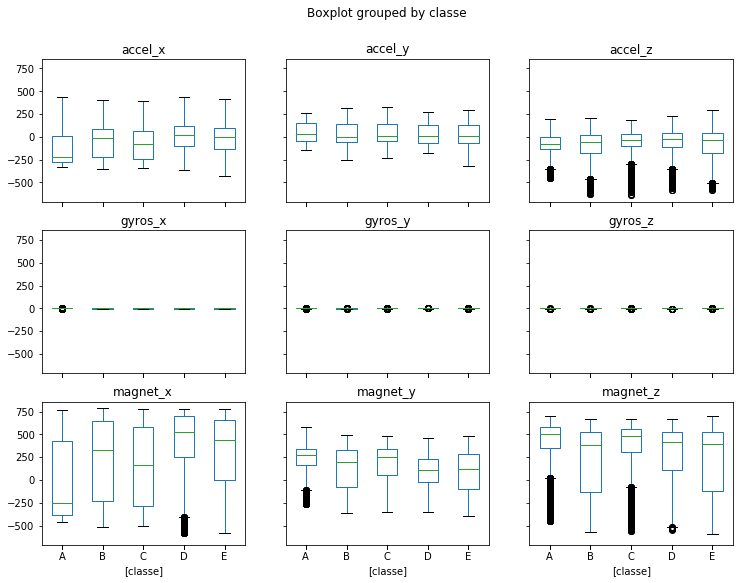

In [107]:
# Boxplot by class considering only the device in the arm
location='arm'
tidy_df.loc[tidy_df['Location']==location, ['accel_x','accel_y','accel_z','gyros_x','gyros_y','gyros_z',
         'magnet_x','magnet_y','magnet_z','classe']].boxplot(by=['classe'],figsize=(12,9),
                                                             return_type='axes',grid=False,layout=(3,3));

#### Anomaly Detection
<a id='Anomaly_Detection'></a>
Before go ahead with this analysis, it's important to be clear that we are working over the whole dataset, and as consequence we can't take actions that provoke data leaking and we can't normalize/scale our data. These restrictions limit the number of possible algorithms that we can use to make this analysis (you can't consider an algorithm that uses distances between points or statistics like the mean or the standard deviation), but univariate strategies like the "Interquartile Range Rule" or multivariate options like "Isolation Forest" are still available.

> 1. **[Interquartile Range Rule](https://en.wikipedia.org/wiki/Interquartile_range)**: The data point into the interval $[Q1-1.5\times IQR, Q3+1.5\times IQR]$, where Q1 and Q3 are the first (25\% lies between the minimum and Q1) and third (75\% lies between the minimum and Q3) quartile, and IQR=Q3-Q1, are inliers, while the points out of this interval are outliers.    
2. **[Isolation Forest](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest)**: The idea here is to determine when an observation is an outlier based on the number of necessary binary partitions to isolate the observation. Outliers should be easily isolated (fewer partitions) while inliers will take more partitions steps.

In [271]:
# Compute the .25 and .75 quantile
quantiles=tidy_df['accel_x'].quantile([0.25,0.75])
IQR=quantiles[0.75]-quantiles[0.25]
from interval import interval
inliers_int=interval([quantiles[0.25]-1.5*IQR,quantiles[0.75]+1.5*IQR])


[True, True, True, True, False]

In [200]:
# Isolation Forest --> Multivariate strategy to find outliers
from sklearn.ensemble import IsolationForest
# Devices locations
location=['arm','forearm','belt','dumbbell']
# Numerical variables
num_variables=['accel_x','accel_y', 'accel_z', 'gyros_x', 'gyros_y','gyros_z', 
               'magnet_x', 'magnet_y', 'magnet_z', 'pitch','roll', 
               'total_accel', 'yaw']
# Classe
classe=['A','B','C','D','E']
result_by_class={}
predic_by_class={}
for clas in classe:
    # variables to store results
    num_observations=[] # Number of observation by locations
    num_outliers=[] # num of detected outliers
    avg_outliers=[] # Average of the number of outliers
    predictions={} # Predictions for each observation
    for this_location in location:
        # Slice the dataset to consider only a specific location
        temporal=tidy_df.loc[(tidy_df['Location']==this_location) & 
                             (tidy_df['classe']==clas),num_variables]
        # Fit the isolation Forest
        clf = IsolationForest(random_state=0).fit(temporal)
        # Make the predictions
        predictions[this_location]=clf.predict(temporal)
        # Update the information
        num_observations.append(len(predictions[this_location]))
        num_outliers.append(sum(predictions[this_location]==-1))
        avg_outliers.append(sum(predictions[this_location]==-1)/len(predictions[this_location]))
    # Save the results of the class in a dictionary 
    result_by_class[clas]=pd.DataFrame({'Location': location,'# Obsv': num_observations,
             '# Outliers': num_outliers, 'Avg Outliers': avg_outliers})
    predic_by_class[clas]={'Prediction':predictions}
# Resume the whole information as a data frame
isolation_f=pd.concat({k: pd.DataFrame(v) for k, v in result_by_class.items()}, axis=0)
isolation_f.reset_index(level=0,inplace=True)
isolation_f.rename(columns={'level_0':'Classe'},inplace=True)
# Include an extra variable with the number of inliers
isolation_f['# Inliers']=isolation_f['# Obsv'] - isolation_f['# Outliers'] 
isolation_f

,Classe,Location,# Obsv,# Outliers,Avg Outliers,# Inliers
0,A,arm,11158,2953,0.264653,8205
1,A,forearm,11158,2304,0.206489,8854
2,A,belt,11158,2104,0.188564,9054
3,A,dumbbell,11158,2650,0.237498,8508
0,B,arm,7593,1679,0.221125,5914
1,B,forearm,7593,2179,0.286975,5414
2,B,belt,7593,1564,0.205979,6029
3,B,dumbbell,7593,1977,0.260371,5616
0,C,arm,6844,1117,0.163209,5727
1,C,forearm,6844,1679,0.245324,5165


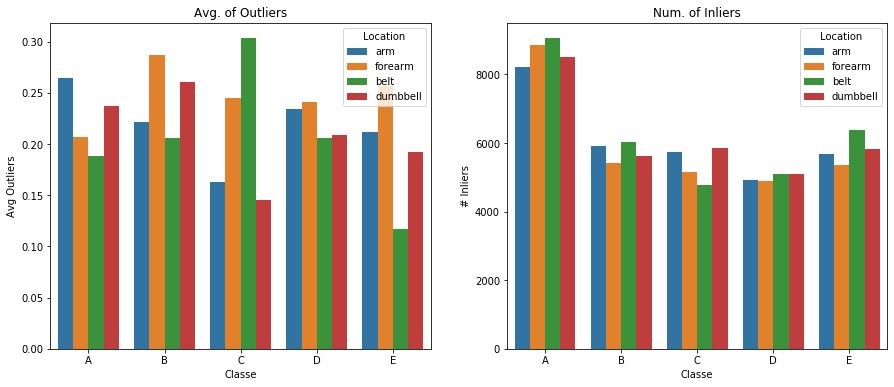

In [243]:
# Average of Outliers by Classe & Location
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False,figsize=(15,6))
sns.barplot(x='Classe',y="Avg Outliers",hue='Location', data=isolation_f,ax=ax1);
sns.barplot(x='Classe',y="# Inliers",hue='Location', data=isolation_f,ax=ax2);
ax1.title.set_text('Avg. of Outliers');
ax2.title.set_text('Num. of Inliers');

In [246]:
# Number of inliers by class
isolation_f.pivot_table(index='Classe',values='# Inliers',aggfunc='sum')

,# Inliers
Classe,
A,34621
B,22973
C,21507
D,20000
E,23242


### Training and Validation Dataset
<a id='Training_and_Validation_Dataset'></a>

Before going forward with a descriptive or exploratory analysis, I think that it's important to split our data into the training and test datasets. Note that I don't speak about a validation dataset, and this is because I am going to use a 10-folk-validation alternative in order to tune the parameter of our machine learning approach. 
> Just to be very clear, the test dataset is going to be used only once time to have an unbiased estimator of the performance of the ML algorithm.    

There is a lot of confusion in the machine learning community about the training, validation, and test dataset. A really nice reading about this can be found in [Jason's blog](https://machinelearningmastery.com/difference-test-validation-datasets/)

Scale

## Feature Selection/Importance
<a id='Feature_Selection_Importance'></a>
* Rememver the scale of the variables!!!!     
https://machinelearningmastery.com/calculate-feature-importance-with-python/

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define the model
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]

In [ ]:
# permutation feature importance with knn for regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = KNeighborsRegressor()
# fit the model
model.fit(X, y)
# perform permutation importance
results = permutation_importance(model, X, y, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
importance

## Classification Model
<a id='Classification_Model'></a>

## Conclusions and Remarks
<a id='Conclusions_and_Remarks'></a>